In [1]:
# Build and clean dataset
import pandas as pd
import altair as alt
import geopandas as gpd
from multiprocessing import Pool
import json
import plotly.express as px
import plotly.graph_objects as go
import pyproj
import math

Based on https://www.ncei.noaa.gov/news/noaa-offers-climate-data-counties NClimDiv

https://www.ncei.noaa.gov/pub/data/cirs/climdiv/

In [2]:
div_weather = pd.read_parquet('climdiv-tmpcdv-v1.0.0-20230504.parquet')
div_weather['state_div'] = div_weather['state_code'] + div_weather['division_number']
div_weather.set_index('state_div', inplace=True)
div_weather.head()

,state_code,division_number,element_code,year,month,value,date
state_div,,,,,,,
01010,01,010,2,1895,01,37.7,1895-01-01
01010,01,010,2,1896,01,39.7,1896-01-01
01010,01,010,2,1897,01,37.3,1897-01-01
01010,01,010,2,1898,01,44.7,1898-01-01
01010,01,010,2,1899,01,39.5,1899-01-01


<Axes: >

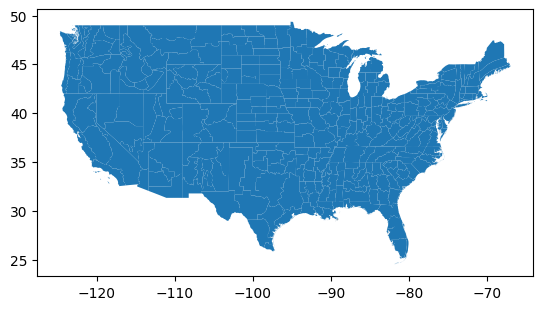

In [3]:
# Read in the shapefile of climate divisions
gdf = gpd.read_file('CONUS_CLIMATE_DIVISIONS.shp/GIS.OFFICIAL_CLIM_DIVISIONS.shp')
# gdf_converted = gdf.to_crs(pyproj.CRS.from_epsg(4326))
gdf_converted = gdf
gdf_converted['division_number'] = gdf_converted['CD_NEW'].apply(lambda x: f'{int(x):02d}0')
gdf_converted['state_code'] = gdf_converted['STATE_FIPS']
gdf_converted['state_div'] = gdf_converted['state_code'] + gdf_converted['division_number']
gdf_converted.set_index('state_div', inplace=True)
gdf_converted.plot()

In [4]:
# # Join the weather data to the shapefile
# gdf_weather_23 = gdf_converted.merge(div_weather.query('year == "2023" and month == "01"'), on = 'state_div', how='left')
# # Create background map to fill in missing values
# foreground = alt.Chart(gdf_weather_23).mark_geoshape().encode(
#     color = 'value:Q',
#     # Add outlines
#     stroke = alt.value('black'),
# ).project(
#     type = 'albersUsa'
# ).properties(
#     width = 800,
#     height= 800
# ).add_params(
#     alt.selection_interval(bind='scales')
# )


# background = alt.Chart(gdf_weather_23).mark_geoshape(
#     color = 'lightgray',
#     stroke = 'darkgrey',
# ).project(
#     type = 'albersUsa'
# ).properties(
#     width = 800,
#     height= 800
# ).add_params(
#     alt.selection_interval(bind='scales')
# )

# chart = background + foreground
# chart

In [18]:
# Join the weather data to the shapefile
gdf_weather = gdf_converted.merge(div_weather, on = 'state_div', how='outer')
gdf_weather_23 = gdf_converted.merge(div_weather.query('year == "2023" and month == "01"'), on = 'state_div', how='outer')

<Axes: >

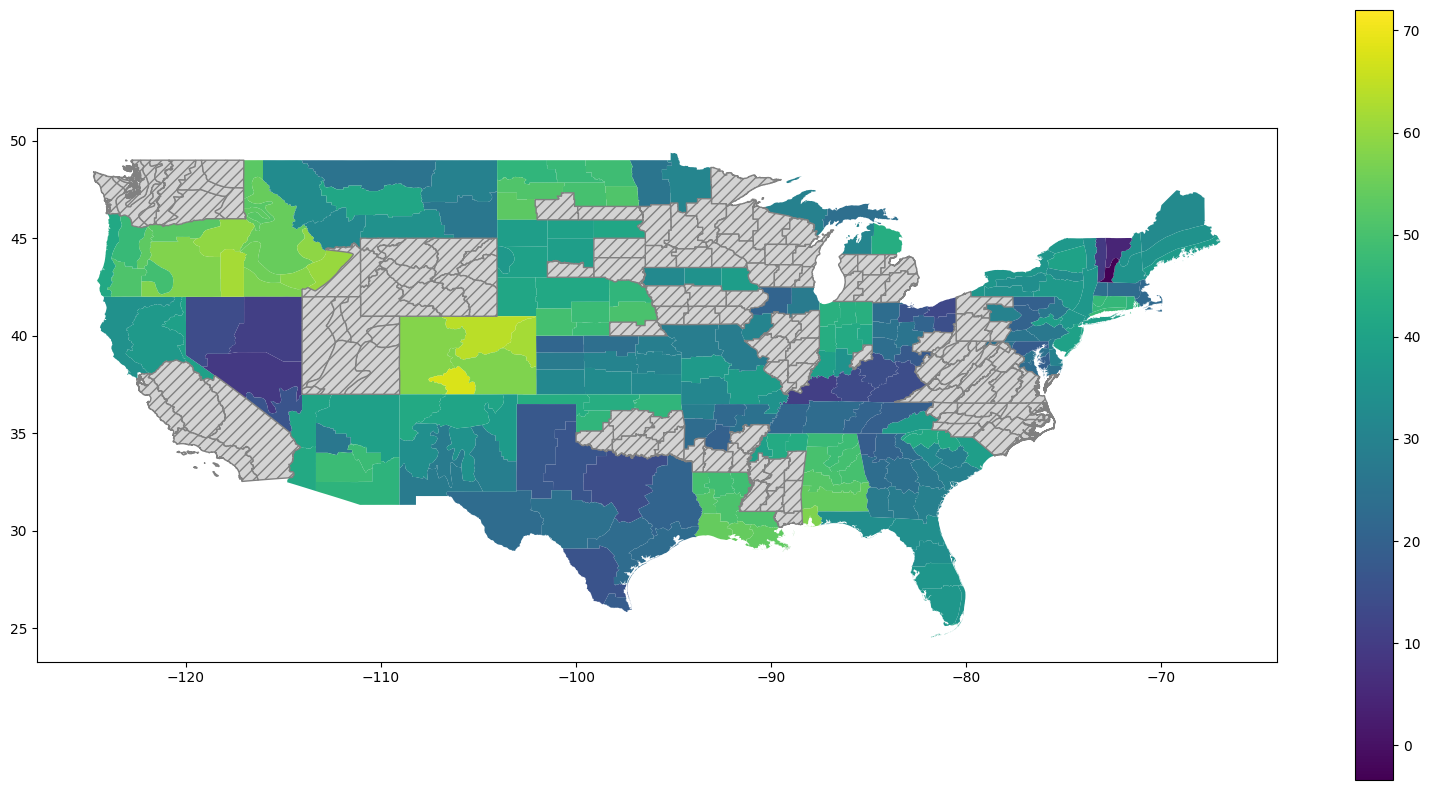

In [19]:
gdf_weather_23.plot(column = 'value', 
                    legend = True, 
                    missing_kwds={
                        "color": "lightgrey",
                        "edgecolor": "grey",
                        "hatch": "///",
                        "label": "Missing values",},
                    figsize = (20,10))

In [34]:
# Create bokeh map
# Import figure
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Viridis256 as palette
from bokeh.transform import linear_cmap
from bokeh.models import GeoJSONDataSource



p = figure(title = "Weather Map",
              x_axis_label = 'Longitude',
                y_axis_label = 'Latitude')




states = p.patches(
    'xs','ys',
    fill_color = 'blue',
    fill_alpha = 0.7,
    line_color = 'black',
    line_width = 0.5,
    source = GeoJSONDataSource(geojson = gdf_weather_23[['geometry','value']].to_json())
)
show(p)

/var/folders/ps/6kqcm3s165zfk_q2d2fw79sr0000gp/T/ipykernel_87669/3424195868.py:23: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  source = GeoJSONDataSource(geojson = gdf_weather_23[['geometry','value']].to_json())


In [33]:
gdf_weather_23.head()

,OBJECTID,STATE,STATE_FIPS,CD_2DIG,STATE_CODE,CLIMDIV,CD_NEW,FIPS_CD,NCDC_GEO_I,NAME,...,geometry,division_number_x,state_code_x,state_code_y,division_number_y,element_code,year,month,value,date
state_div,,,,,,,,,,,,,,,,,,,,,
35050,91.0,New Mexico,35,05,29.0,2905.0,5.0,3505,1.0,CENTRAL VALLEY,...,"POLYGON ((-105.87800 33.24400, -105.98500 33.2...",050,35,35,050,2,2023,01,27.8,2023-01-01
35060,92.0,New Mexico,35,06,29.0,2906.0,6.0,3506,2.0,CENTRAL HIGHLANDS,...,"POLYGON ((-105.14900 32.64000, -105.22300 32.5...",060,35,35,060,2,2023,01,34.9,2023-01-01
16010,93.0,Idaho,16,01,10.0,1001.0,1.0,1601,3.0,PANHANDLE,...,"POLYGON ((-116.04882 47.97673, -116.11800 48.0...",010,16,16,010,2,2023,01,52.6,2023-01-01
16020,94.0,Idaho,16,02,10.0,1002.0,2.0,1602,4.0,NORTH CENTRAL PRAIRIES,...,"POLYGON ((-116.15700 45.71800, -116.26300 45.8...",020,16,16,020,2,2023,01,52.3,2023-01-01
16040,96.0,Idaho,16,04,10.0,1004.0,4.0,1604,6.0,CENTRAL MOUNTAINS,...,"POLYGON ((-113.83465 45.52065, -113.88700 45.5...",040,16,16,040,2,2023,01,54.5,2023-01-01
